## CNN Classifier for MNIST

In [203]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

class CNN_classifier(torch.nn.Module):

    def __init__(self, L, num_class):
        super(CNN_classifier, self).__init__()

        self.conv = torch.nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, stride = 1, padding = 1, bias=False)
        #self.pool = torch.nn.Identity()
        self.pool = torch.nn.MaxPool2d( kernel_size = 2)

        self._dim_to_linear = None
        self._get_flattened_conv_output_size(L)

        self.fc = torch.nn.Linear(self._dim_to_linear, num_class)

    def _get_flattened_conv_output_size(self, L):
        """Pass a dummy tensor through conv layers to compute FC layer size"""
        with torch.no_grad():
            # Pass a dummy input with shape (1, 1, L, L) to match the Conv2d input requirements
            # conv layers expect (batch_size, num_channels, ...data dimension... )
            dummy_input = torch.randn(1, 1, L, L)
            dummy_output = self.pool(self.conv(dummy_input))
            self._dim_to_linear = dummy_output.numel()  # Compute feature count
    
    def forward(self, x):
        x = F.relu(self.pool(self.conv(x)))
        x = torch.flatten(x, start_dim = 1)  # Flatten from the first non-batch dimension
        x = self.fc(x)
        return F.log_softmax(x, dim=1)  
    
    def train_model(self, train_loader, num_epochs):

        criterion = torch.nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters())  

        self.train()
        for epoch in range(num_epochs):
            running_loss, correct, total = 0.0, 0, 0
            
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            # Print epoch results
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    def eval_model(self, test_loader):
        self.eval()
        num_data = len(test_loader.dataset)
        num_batches = len(test_loader)

        with torch.no_grad():
            test_loss, correct = 0.0, 0
            for inputs, labels in test_loader:
                outputs = self(inputs)

                test_loss += criterion(outputs, labels)
                _, predictions = torch.max(outputs, 1)
                correct += (predictions == labels).sum().item()
            
            accuracy = 100*correct/num_data
            average_loss = test_loss/num_batches

        print(f"Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy:.2f}%")     


class MLP_classifier(torch.nn.Module):

    def __init__(self, L, N_hidden, num_class):
        super(MLP_classifier, self).__init__()

        self.fc1 = torch.nn.Linear( L**2, N_hidden)
        self.fc2 = torch.nn.Linear(N_hidden, num_class)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim = 1)  # Flatten from the first non-batch dimension
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  
    
    def train_model(self, train_loader, num_epochs):

        criterion = torch.nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters())  

        self.train()
        for epoch in range(num_epochs):
            running_loss, correct, total = 0.0, 0, 0
            
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            # Print epoch results
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    def eval_model(self, test_loader):
        self.eval()
        num_data = len(test_loader.dataset)
        num_batches = len(test_loader)

        with torch.no_grad():
            test_loss, correct = 0.0, 0
            for inputs, labels in test_loader:
                outputs = self(inputs)

                test_loss += criterion(outputs, labels)
                _, predictions = torch.max(outputs, 1)
                correct += (predictions == labels).sum().item()
            
            accuracy = 100*correct/num_data
            average_loss = test_loss/num_batches

        print(f"Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy:.2f}%")     



In [186]:
# Load MNIST dataset
train_data = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

image, label = train_data[0]
print(label)
L = image.shape[1]
num_class = len(set([label for image, label in train_data]))

5


In [199]:
MLP = MLP_classifier( L = L, N_hidden = 50, num_class = num_class)

num_epochs = 10*1
MLP.train_model( train_loader, num_epochs)
MLP.eval_model(test_loader)

Epoch 1/10, Loss: 0.4215, Accuracy: 89.12%
Epoch 2/10, Loss: 0.2175, Accuracy: 93.83%
Epoch 3/10, Loss: 0.1669, Accuracy: 95.16%
Epoch 4/10, Loss: 0.1355, Accuracy: 96.07%
Epoch 5/10, Loss: 0.1129, Accuracy: 96.72%
Epoch 6/10, Loss: 0.0969, Accuracy: 97.22%
Epoch 7/10, Loss: 0.0843, Accuracy: 97.52%
Epoch 8/10, Loss: 0.0751, Accuracy: 97.80%
Epoch 9/10, Loss: 0.0663, Accuracy: 98.05%
Epoch 10/10, Loss: 0.0597, Accuracy: 98.22%
Test Loss: 0.0897, Test Accuracy: 97.40%


In [204]:
CNN = CNN_classifier( L = L, num_class = num_class)

num_epochs = 10*1
CNN.train_model( train_loader, num_epochs)
CNN.eval_model(test_loader)


Epoch 1/10, Loss: 0.3184, Accuracy: 91.15%
Epoch 2/10, Loss: 0.1378, Accuracy: 96.10%
Epoch 3/10, Loss: 0.0977, Accuracy: 97.21%
Epoch 4/10, Loss: 0.0777, Accuracy: 97.78%
Epoch 5/10, Loss: 0.0656, Accuracy: 98.07%
Epoch 6/10, Loss: 0.0591, Accuracy: 98.28%
Epoch 7/10, Loss: 0.0523, Accuracy: 98.46%
Epoch 8/10, Loss: 0.0479, Accuracy: 98.53%
Epoch 9/10, Loss: 0.0433, Accuracy: 98.68%
Epoch 10/10, Loss: 0.0395, Accuracy: 98.84%
Test Loss: 0.0643, Test Accuracy: 97.92%


## CNN Classifier as a thermometer for the Ising model 

In [153]:
#---- packages
import numpy as np, pandas as pd, matplotlib.pyplot as plt, torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from time import time

#---- parallel computation packages 
from joblib import Parallel, delayed
import multiprocessing
from functools import partial
num_cores = multiprocessing.cpu_count()

#----- Monte Carlo computations

def hotstart(L): 
    ''' hotstart(L) generates an LxL Matrix of random spin '''
    return np.random.choice([-1,1],size=(L,L))

def Metropolis_update(Latt, beta, N_burnin, N_measure, N_separation):
    """Perform Metropolis update for Monte Carlo simulation"""
    H = 0  # External field
    J = 1  # Coupling constant
    L = len(Latt)
    
    # Initialize magnetization and energy
    m = np.sum(Latt)
    e = 0

    def update_spin(Latt, i, j):
        """Helper function to flip a spin and update energy and magnetization"""
        dE = -2 * (-J) * Latt[i, j] * (Latt[(i + 1) % L, j] + Latt[(i - 1) % L, j] +
                                       Latt[i, (j + 1) % L] + Latt[i, (j - 1) % L])
        dE += 2 * H * Latt[i, j]
        
        # Accept or reject the spin flip
        if np.random.rand() < np.exp(-beta * dE):
            Latt[i, j] *= -1
            return dE, 2 * Latt[i, j]  # Energy and magnetization change
        return 0, 0

    # Burn-in stage: perform updates without storing data
    for _ in range(N_burnin):
        i, j = np.random.randint(0, L, size=2)  # Randomly select indices
        dE, dm = update_spin(Latt, i, j)
        e += dE
        m += dm

    # Measurement stage: collect energy and magnetization traces
    trace_Latt = []
    trace = np.zeros((N_measure, 2))  # Energy and magnetization trace
    for s in range(N_measure):
        for _ in range(N_separation):
            i, j = np.random.randint(0, L, size=2)  # Randomly select indices
            dE, dm = update_spin(Latt, i, j)
            e += dE
            m += dm

        trace[s] = [m, e]
        trace_Latt.append(Latt.copy())  # Store lattice configuration after each measurement

    return beta, trace, trace_Latt


#---- Ising Monte Carlo data generation
#---- generates N_measure roughly decorrelated spin configurations per temperature

L = 8
N_sites = L**2
N_burnin = 100*N_sites
N_measure = 2*10**3
N_separation = 30*N_sites

Nt = num_cores*3
beta_range = np.linspace(.2, 1, Nt)

t0 = time()

#--- parallelize over temperature, output is a list with each element being [trace, trace_Latt] for each temperature 

innerm_ = partial(Metropolis_update,  N_burnin = N_burnin, N_measure = N_measure, N_separation = N_separation )
output = Parallel(n_jobs = num_cores)(delayed(innerm_)(hotstart(L), b) for b in beta_range)

spin_configurations = np.stack([trace_Latt for beta, trace, trace_Latt in output], axis=0)
spin_configurations = spin_configurations.reshape((-1, 1, L, L))
spin_configurations = torch.tensor(spin_configurations, dtype = torch.float32)

beta_labels = np.repeat([beta for beta, trace, trace_Latt in output], N_measure)
beta_labels = np.digitize(beta_labels, beta_range) - 1
beta_labels = torch.tensor(beta_labels, dtype = torch.long)
#beta_labels_one_hot = torch.nn.functional.one_hot(beta_labels.to(torch.int64), num_classes=Nt)

train_dataset = TensorDataset(spin_configurations, beta_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

t1 = time()
m, s = divmod(t1-t0, 60)
h, m = divmod(m, 60)
print(f"Computation time = {h} hours, {m} minutes, {s} seconds")

Computation time = 0.0 hours, 2.0 minutes, 33.778095722198486 seconds


In [182]:
class CNN_thermometer(torch.nn.Module):

    def __init__(self, L, num_labels):
        super(CNN_thermometer, self).__init__()

        self.conv = torch.nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 2, stride = 2, padding = 0)
        #self.pool = torch.nn.MaxPool2d(2)
        self.pool = torch.nn.Identity()

        self._dim_to_linear = None
        self._get_flattened_conv_output_size(L)

        self.fc = torch.nn.Linear(self._dim_to_linear, num_labels)

    def _get_flattened_conv_output_size(self, L):
        """Pass a dummy tensor through conv layers to compute FC layer size"""
        with torch.no_grad():
            # Pass a dummy input with shape (1, 1, L, L) to match the Conv2d input requirements
            # conv layers expect (batch_size, num_channels, ...data dimension... )
            dummy_input = torch.randn(1, 1, L, L)
            dummy_output = self.pool(self.conv(dummy_input))
            self._dim_to_linear = dummy_output.numel()  # Compute feature count
    
    def forward(self, x):
        x = F.relu(self.pool(self.conv(x)))
        x = torch.flatten(x, start_dim = 1)  # Flatten from the first non-batch dimension
        x = self.fc(x)
        return F.log_softmax(x, dim=1)  # Apply softmax across the feature dimension
        #return x
    
    def train_model(self, train_loader, num_epochs):

        criterion = torch.nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters())  

        self.train()
        for epoch in range(num_epochs):
            running_loss, correct, total = 0.0, 0, 0
            
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            # Print epoch results
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
    
    def plot_fc_weights_heatmap(self):
        """
        Plot a heatmap of the weights from the fully connected (FC) layer
        with output nodes on the x-axis and hidden neurons on the y-axis .
        """
        
        weights = self.fc.weight.data.numpy()

        num_labels = weights.shape[0]  
        num_hidden_neurons = weights.shape[1]  

        # Plot the heatmap with output nodes on the x-axis and hidden neurons on the y-axis
        fig, ax = plt.subplots(figsize=(12, 8))
        cax = ax.imshow(np.transpose(weights), cmap='hot', aspect='auto')
        fig.colorbar(cax)

        ax.set_xlabel("Output Nodes (Temperature Labels)")
        x_ticks = np.arange(0, num_labels, 10)
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_ticks)
        
        ax.set_ylabel("Hidden Neurons")
        y_ticks = np.arange(0, num_hidden_neurons, num_hidden_neurons // 10)
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_ticks)

        plt.title("Heatmap of Weights from the Fully Connected Layer")
        plt.tight_layout()
        plt.show()

class MLP_thermometer(torch.nn.Module):

    def __init__(self, L, N_hidden, num_labels):
        super(MLP_thermometer, self).__init__()
        self.fc1 = torch.nn.Linear( L**2, N_hidden)
        self.fc2 = torch.nn.Linear(N_hidden, num_labels)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim = 1) # Flatten from the first non-batch dimension
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  # Apply softmax across the feature dimension
        #return x
    
    def train_model(self, train_loader, num_epochs):

        criterion = torch.nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters())  

        self.train()
        for epoch in range(num_epochs):
            running_loss, correct, total = 0.0, 0, 0
            
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            # Print epoch results
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
    
    def plot_fc_weights_heatmap(self):
        """
        Plot a heatmap of the weights from the fully connected (FC) layer
        with output nodes on the x-axis and hidden neurons on the y-axis .
        """
        
        weights = self.fc2.weight.data.numpy()  

        # Plot the heatmap with output nodes on the x-axis and hidden neurons on the y-axis
        fig, ax = plt.subplots(figsize=(12, 8))
        cax = ax.imshow(np.transpose(weights), cmap='hot', aspect='auto')
        fig.colorbar(cax)

        ax.set_xlabel("Output Nodes (Temperature Labels)")
        num_labels = weights.shape[0] 
        x_ticks = np.arange(0, num_labels, 10)
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_ticks)
        
        ax.set_ylabel("Hidden Neurons")
        num_hidden_neurons = weights.shape[1] 
        y_ticks = np.arange(0, num_hidden_neurons, num_hidden_neurons // 10)
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_ticks)

        plt.title("Heatmap of Weights from the Fully Connected Layer")
        plt.tight_layout()
        plt.show()

In [183]:
CNN = CNN_thermometer( L = L, num_labels = Nt)

num_epochs = 10**2 
CNN.train_model( train_loader, num_epochs)

Epoch 1/100, Loss: 2.3977, Accuracy: 14.90%
Epoch 2/100, Loss: 2.2237, Accuracy: 17.79%
Epoch 3/100, Loss: 2.1863, Accuracy: 18.72%
Epoch 4/100, Loss: 2.1702, Accuracy: 19.14%
Epoch 5/100, Loss: 2.1601, Accuracy: 19.27%
Epoch 6/100, Loss: 2.1542, Accuracy: 19.42%
Epoch 7/100, Loss: 2.1497, Accuracy: 19.53%
Epoch 8/100, Loss: 2.1463, Accuracy: 19.28%
Epoch 9/100, Loss: 2.1446, Accuracy: 19.86%
Epoch 10/100, Loss: 2.1421, Accuracy: 19.73%
Epoch 11/100, Loss: 2.1415, Accuracy: 19.78%
Epoch 12/100, Loss: 2.1404, Accuracy: 19.55%
Epoch 13/100, Loss: 2.1385, Accuracy: 19.75%
Epoch 14/100, Loss: 2.1371, Accuracy: 19.90%
Epoch 15/100, Loss: 2.1369, Accuracy: 20.06%
Epoch 16/100, Loss: 2.1354, Accuracy: 20.05%
Epoch 17/100, Loss: 2.1354, Accuracy: 20.02%
Epoch 18/100, Loss: 2.1344, Accuracy: 20.11%
Epoch 19/100, Loss: 2.1336, Accuracy: 20.30%
Epoch 20/100, Loss: 2.1337, Accuracy: 20.00%
Epoch 21/100, Loss: 2.1326, Accuracy: 19.97%
Epoch 22/100, Loss: 2.1325, Accuracy: 20.21%
Epoch 23/100, Loss:

In [178]:
MLP = MLP_thermometer( L = L, N_hidden = 80, num_labels = Nt)

num_epochs = 10**2 
MLP.train_model( train_loader, num_epochs)

Epoch 1/100, Loss: 2.3742, Accuracy: 15.33%
Epoch 2/100, Loss: 2.2147, Accuracy: 18.43%
Epoch 3/100, Loss: 2.1811, Accuracy: 19.04%
Epoch 4/100, Loss: 2.1633, Accuracy: 19.64%
Epoch 5/100, Loss: 2.1516, Accuracy: 20.14%
Epoch 6/100, Loss: 2.1418, Accuracy: 19.96%
Epoch 7/100, Loss: 2.1334, Accuracy: 20.58%
Epoch 8/100, Loss: 2.1283, Accuracy: 20.89%
Epoch 9/100, Loss: 2.1210, Accuracy: 21.07%
Epoch 10/100, Loss: 2.1170, Accuracy: 21.25%
Epoch 11/100, Loss: 2.1108, Accuracy: 21.48%
Epoch 12/100, Loss: 2.1068, Accuracy: 21.73%
Epoch 13/100, Loss: 2.1044, Accuracy: 21.67%
Epoch 14/100, Loss: 2.0987, Accuracy: 22.07%
Epoch 15/100, Loss: 2.0955, Accuracy: 22.12%
Epoch 16/100, Loss: 2.0931, Accuracy: 22.38%
Epoch 17/100, Loss: 2.0893, Accuracy: 22.57%
Epoch 18/100, Loss: 2.0884, Accuracy: 22.38%
Epoch 19/100, Loss: 2.0862, Accuracy: 22.47%
Epoch 20/100, Loss: 2.0826, Accuracy: 22.54%
Epoch 21/100, Loss: 2.0803, Accuracy: 22.87%
Epoch 22/100, Loss: 2.0774, Accuracy: 23.10%
Epoch 23/100, Loss:

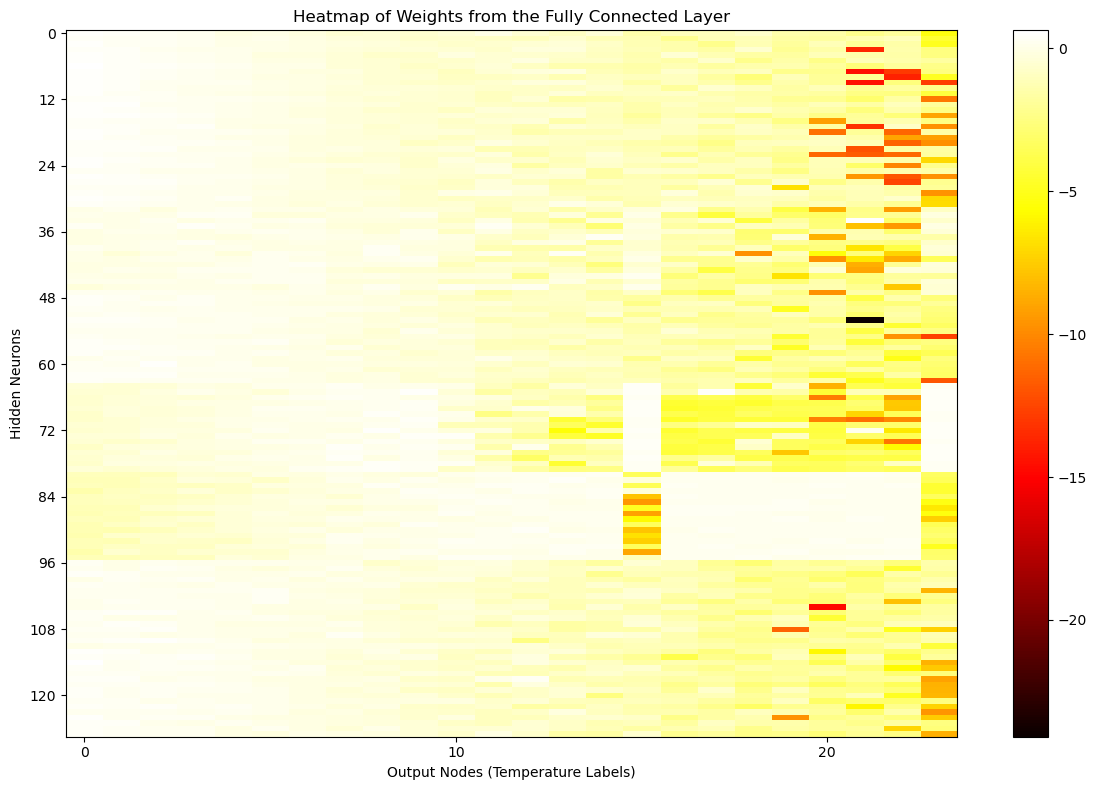

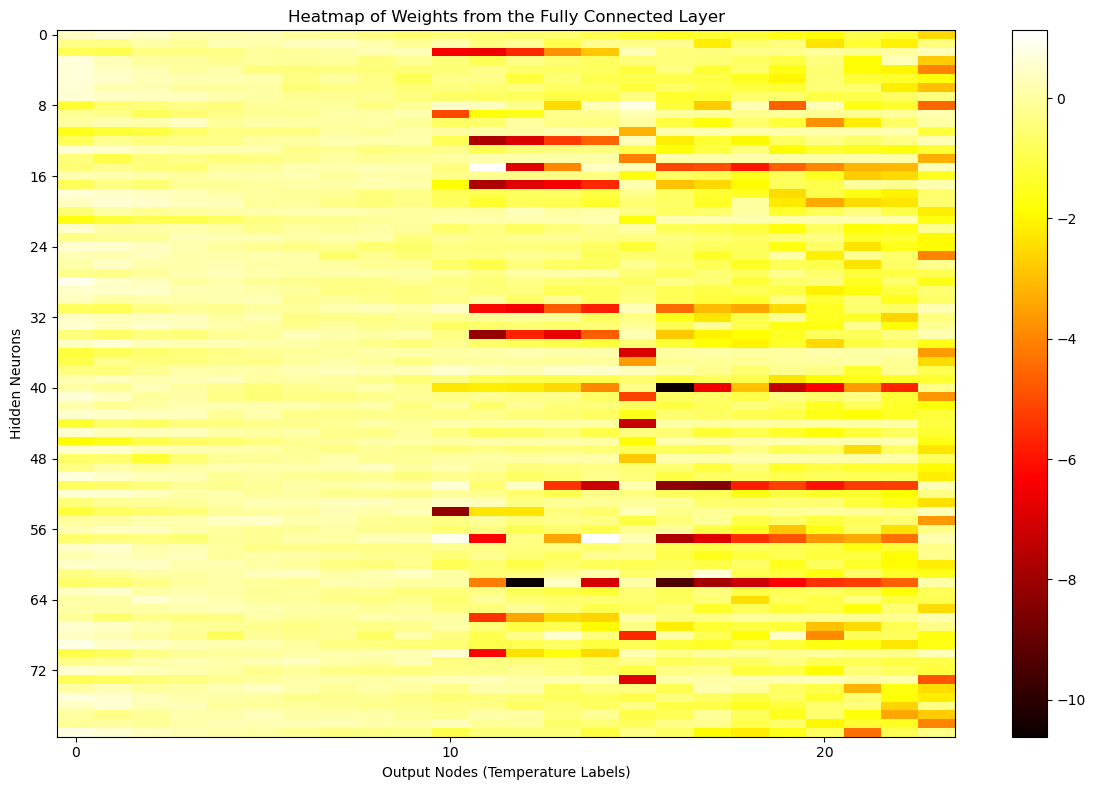

In [184]:
CNN.plot_fc_weights_heatmap()
MLP.plot_fc_weights_heatmap()